# Deepfake Detection with VGG19

by

Name: *Ventsislav V. Dimitrov*  
SoftUni username: *nechoventsi*

Deep learining models are getting really good at generating fake human faces. This constitutes a real problem for various services, like automatic ID verification (i.e. for banking apps), fake persona representation on social media, deepfake videos, catfishing, etc.

With this model, we're aiming to test a Transfer Learning strategy for the detection and classification of real and fake human faces.

The dataset used is a collection of human faces, 70 000 of which are real photographs of people (the [Flickr- Faces-HQ](https://github.com/NVlabs/ffhq-dataset) (FFHQ) dataset collected by Nvidia [1]), while the other 70 000 are GAN-generated fake human faces. The dataset used in the current work is [available on Kaggle](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces) [2] and is pre-split into train, validation and test sets.

## 1. Imports

In [2]:
import os
import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics

## 2. Constants

In [3]:
# Directory containing the data:
data_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"

# Define the classes as variables:
data_classes = os.listdir(os.path.join(data_path, "train"))
data_classes

## 3. Check data

Create a dataframe to check the length of the dataset, and the value counts for the train, validation and test sets.  
Plot sample images to check the resolution and number of channels (should be RGB).

In [4]:
data_dict = {"img_path":[],"label":[],"part":[]}

for part in os.listdir(data_path):
    for label in os.listdir(data_path + "/" + part):
        for img in glob.glob(data_path + part + "/" + label + "/" + "*.jpg"):
            data_dict["img_path"].append(img)
            data_dict["label"].append(label)
            data_dict["part"].append(part)
df = pd.DataFrame(data_dict)

In [5]:
df.head()

,img_path,label,part
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid


In [6]:
# Classes counts:
df["label"].value_counts()

fake    70000
real    70000
Name: label, dtype: int64

In [7]:
# Train, validation, test counts:
df["part"].value_counts()

train    100000
valid     20000
test      20000
Name: part, dtype: int64

Sample `fake` image:


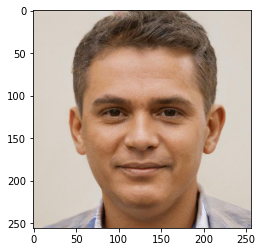


Sample `real` image:


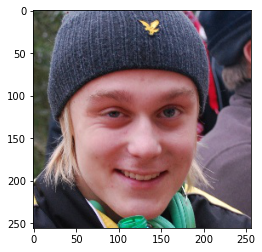

In [8]:
# Plot a fake face:
print(f"Sample `{data_classes[0]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0])))
plt.show()

# Plot a real face:
print(f"\nSample `{data_classes[1]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0])))
plt.show()

In [9]:
# Load a sample fake face image:
sample_fake_img  = load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0]))
# Convert the image into array representation to check dimensions:
sample_fake_array = img_to_array(sample_fake_img)
# Show the shape:
print(f"Shape of `{data_classes[0]}` images: {sample_fake_array.shape}")

# Load a sample real face image:
sample_real_img  = load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0]))
# Convert the image into array representation to check dimensions:
sample_real_array = img_to_array(sample_real_img)
# Show the shape:
print(f"Shape of `{data_classes[1]}` images: {sample_real_array.shape}")

Shape of `fake` images: (256, 256, 3)
Shape of `real` images: (256, 256, 3)


## 4. Construct dataset

In [10]:
# Define a data generator function that will limit repetitive code, 
# as we have data pre-split into train, validation and test sets.
def get_data_generator(data_directory, class_mode, batch_size=32, resize_to=(256, 256), preprocessing_function=None):
    """Create a data generator from a directory containing images.

    Params:
    -------
    data_directory :: string  
        The path containing the image data  
    class_mode :: str  
        One of 'categorical', 'binary', 'sparse', 'input', or `None`.  
        Determines the type of label arrays that are returned:  
            - 'categorical' will be 2D one-hot encoded labels;  
            - 'binary' will be 1D binary labels;  
            - 'sparse' will be 1D integer labels;  
            - 'input' will be images identical to input images (mainly used to work with autoencoders).  
    batch_size :: int  
        Custom batch size. Default: 32  
    resize_to :: tuple  
        New image size. Default: (256, 256)  
    preprocessing_function :: function  
        The images pre-processing function to use for the data generator. Default: `None`

    Returns:
    --------
    data_generator :: keras DirectoryIterator  
        The iterator object to load the data from directory"""

    # Instantiate the generator, normalise pixel values:
    img_generator = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=preprocessing_function)

    # Generate data. Set batch size, class mode and image size.
    # Don't forget seed for reproducibility:
    data_generator = img_generator.flow_from_directory(directory=data_directory,
                                                       batch_size=batch_size,
                                                       class_mode=class_mode,
                                                       target_size=resize_to,
                                                       seed=666)

    # Return the generated data:
    return data_generator

In [ ]:
# Initial batch size:
BATCH_SIZE = 32

In [11]:
# Create the training set generator:
train_generator = get_data_generator(data_directory=data_path+"train/",
                                     class_mode="binary",
                                     batch_size=BATCH_SIZE,
                                     resize_to=(224, 224),
                                     preprocessing_function=preprocess_input)
# Create the validation set generator:
val_generator = get_data_generator(data_directory=data_path+"valid/",
                                   class_mode="binary",
                                   batch_size=BATCH_SIZE,
                                   resize_to=(224, 224),
                                   preprocessing_function=preprocess_input)
# Create the test set generator:
test_generator = get_data_generator(data_directory=data_path+"test/",
                                    class_mode="binary",
                                    batch_size=1,
                                    resize_to=(224, 224),
                                    preprocessing_function=preprocess_input)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## 5. Transfer learning with VGG19

Here we will test the [VGG19](https://keras.io/api/applications/vgg/) pre-trained model [3], on top of which we will build a transfer learning algorithm.

In [12]:
# Instantiate the VGG19 model:
base_VGG19 = VGG19(include_top=False,
                   weights="imagenet",
                   input_shape=(224, 224, 3))

# Freeze all layers of the VGG19 model so as to not change the pre-learned weights:
base_VGG19.trainable = False

2023-01-31 09:38:18.339178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 09:38:18.340168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 09:38:18.432676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 09:38:18.433522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 09:38:18.434249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 0s 0us/step


### 5.1. Feature extraction

VGG19 is a convolutional neural network trained on the large ImageNet dataset, so it should be useful to build the model for the task we're exploring currently. We will use VGG19 as-is (all layers frozen, so we don't change the pre-trained weights; see the code above). We will only instantiate a `GlobalAveragePooling2D` layer to lower the dimensionality of the VGG19 output, after which we will put two `Dense` layers with 512 and 256 units respectively (we have quite a big dataset of human faces, so lets give the new model a chance to learn complex features.

For model parameters, we will use `binary crossentropy` (useful for classification tasks), the robust Adam optimiser [4] and `accuracy` as a metric.

In [13]:
# GlobalAveragePooling2D layer for flattening of the output from the VGG19 model:
x = GlobalAveragePooling2D()(base_VGG19.output)
# Fully connected dense layer:
x = Dense(512, activation="relu")(x)
# Another fully connected dense layer:
x = Dense(256, activation="relu")(x)
# Final dense layer for final prediction. 
# Sigmoid activation for binary classification:
predictions = Dense(1, activation="sigmoid")(x)

# Create a new model with VGG19 as a base:
model = Model(inputs=base_VGG19.input, outputs=predictions)

# Initial learning rate for the optimiser:
LR = 0.001

# Instantiate the Adam optimizer with a specified learning rate:
optimizer = Adam(learning_rate=LR)

# Compile the model with binary crossentropy (loss function for binary classification), 
# the predefined Adam optimizer.
# Use accuracy as a metric:
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [14]:
# Model summary:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
# Calculate the number of steps per epoch:
train_steps = 100000 // BATCH_SIZE
val_steps = 20000 // BATCH_SIZE

# Instantiate early stopping for a callback:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

# Time the training:
start_time = time.time()

# Fit model with generator:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=12,
                    callbacks=[early_stopping])

# Time the training:
end_time = time.time()
print(f"Training time: {(end_time - start_time) / 60} minutes.")

2023-01-31 09:38:45.640802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-01-31 09:38:47.780085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3125/3125 [==============================] - 1269s 402ms/step - loss: 0.5517 - accuracy: 0.7179 - val_loss: 0.5061 - val_accuracy: 0.7556
Epoch 2/12
3125/3125 [==============================] - 630s 201ms/step - loss: 0.4974 - accuracy: 0.7585 - val_loss: 0.4713 - val_accuracy: 0.7746
Epoch 3/12
3125/3125 [==============================] - 597s 191ms/step - loss: 0.4732 - accuracy: 0.7733 - val_loss: 0.4671 - val_accuracy: 0.7795
Epoch 4/12
3125/3125 [==============================] - 617s 197ms/step - loss: 0.4574 - accuracy: 0.7835 - val_loss: 0.4490 - val_accuracy: 0.7904
Epoch 5/12
3125/3125 [==============================] - 593s 190ms/step - loss: 0.4455 - accuracy: 0.7899 - val_loss: 0.4525 - val_accuracy: 0.7915
Epoch 6/12
3125/3125 [==============================] - 582s 186ms/step - loss: 0.4336 - accuracy: 0.7979 - val_loss: 0.4469 - val_accuracy: 0.7936
Epoch 7/12
3125/3125 [==============================] - 624s 200ms/step - loss: 0.4228 - accuracy: 0.8048 - val_loss: 0.43

#### 5.1.1. Save the model for future reference and/or use

In [16]:
# Save the model object:
model.save("FeatureExtraction_VGG19_model.h5", save_format="h5")
# # Save the history to a DataFrame:
history_df = pd.DataFrame(history.history)
# # Save the history DataFrame to a file:
history_df.to_csv("FeatureExtraction_VGG19_history.csv", index=False)

#### 5.1.2. Model performance exploration

Following is a simple exploration of the model performance, along with an evaluation on the testing part of the dataset.

In [17]:
def plot_metric(history, metric):
    """Plot the chosen metric curves for eaasy visualisation.

    Params:
    -------
    history :: keras History object  
        The information for events during training  
    metric :: str  
        The metric of choice to plot"""

    # Train metric:
    train_metric = history.history[metric]
    # Validation metric:
    val_metric = history.history["val_" + metric]
    # The range of epochs for the X axis:
    epochs = range(len(train_metric))
    # Plot the epochs on the X axis vs. the metric on the Y axis:
    plt.plot(epochs, train_metric)
    plt.plot(epochs, val_metric)
    # Title, labels, legend:
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    # Show plot:
    plt.show()

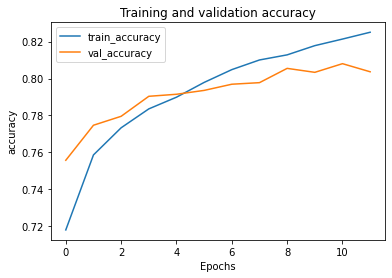

In [18]:
# Plot training and validation accuracy curves:
plot_metric(history=history, metric="accuracy")

In [19]:
# Run model.predict on the unseen test data:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

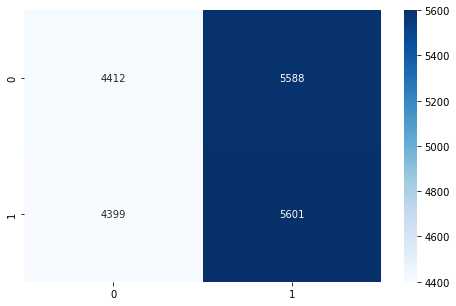

In [20]:
# Show a confusion matrix for the test predictions:
plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [21]:
# Check Area Under the Curve score:
print("ROC-AUC Score:", round(metrics.roc_auc_score(y_test, y_pred), 2))
# Check average precision score:
print("AP Score:", round(metrics.average_precision_score(y_test, y_pred), 2))

# Show classification report:
print("\n", metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.5
AP Score: 0.5

               precision    recall  f1-score   support

           0       0.50      0.44      0.47     10000
           1       0.50      0.56      0.53     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



The model does not appear to perform good at all (accuracy around 50%). This was expected, having in mind that the ImageNet dataset is similar to the one we have, nevertheless way more diverse.

Our next step should be to unfreeze a few of the last layers of the base VGG19 model, so it can learn the features of our particular dataset better. In Deep Neural Networks, the first layers are the ones that learn the most basic features of, for example, an image. The deeper we go, the more complex the learned features become. Because of this fact, and the way VGG19 was trained (on a variety of images), we should be able to obtain an increased performance by letting the base model learn some specific face features in its deeper layers, before passing its output to the `Dense` layers we have constructed on top of it.

### 5.2. Fine-tuning

We will unfreeze the last two convolutional layers of the base VGG19 model and re-train the whole algorithm with a lower learning rate.

In [22]:
# Unfreeze the last layers:
for layer in model.layers[-7:]:
    layer.trainable = True

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now around 25% of all the final model layers are trainable. Lets define a new, lower learning rate, re-compile the model and train.

In [24]:
# Choose a new learning rate and re-instantiate the Adam optimizer:
NEW_LR = 0.0001
new_optimizer = Adam(learning_rate=NEW_LR)

# Compile the model with binary crossentropy (loss function for binary classification), 
# the predefined Adam optimizer.
# Use accuracy as a metric:
new_model.compile(loss="binary_crossentropy", optimizer=new_optimizer, metrics=["accuracy"])

In [25]:
# Instantiate early stopping for a callback:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

# Time the training:
start_time = time.time()

# Fit model with generator:
new_history = new_model.fit(train_generator,
                            steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps,
                            epochs=12,
                            callbacks=[early_stopping])

# Time the training:
end_time = time.time()
print(f"Training time: {(end_time - start_time) / 60} minutes.")

Epoch 1/12
3125/3125 [==============================] - 637s 203ms/step - loss: 0.3492 - accuracy: 0.8456 - val_loss: 0.2938 - val_accuracy: 0.8701
Epoch 2/12
3125/3125 [==============================] - 631s 202ms/step - loss: 0.1740 - accuracy: 0.9303 - val_loss: 0.1500 - val_accuracy: 0.9399
Epoch 3/12
3125/3125 [==============================] - 628s 201ms/step - loss: 0.1050 - accuracy: 0.9598 - val_loss: 0.1418 - val_accuracy: 0.9458
Epoch 4/12
3125/3125 [==============================] - 615s 197ms/step - loss: 0.0688 - accuracy: 0.9735 - val_loss: 0.1771 - val_accuracy: 0.9349
Epoch 5/12
3125/3125 [==============================] - 617s 197ms/step - loss: 0.0503 - accuracy: 0.9811 - val_loss: 0.1534 - val_accuracy: 0.9464
Epoch 6/12
3125/3125 [==============================] - 620s 198ms/step - loss: 0.0376 - accuracy: 0.9861 - val_loss: 0.1495 - val_accuracy: 0.9507
Epoch 00006: early stopping
Training time: 62.46536054213842 minutes.


#### 5.2.1. Save the model for future reference and/or use

In [26]:
# Save the model object:
new_model.save("FineTuning_VGG19_model.h5", save_format="h5")
# # Save the history to a DataFrame:
new_history_df = pd.DataFrame(new_history.history)
# # Save the history DataFrame to a file:
new_history_df.to_csv("FineTuning_VGG19_history.csv", index=False)

#### 5.2.2. Model performance exploration

Following, as for the feature extraction step above, is a simple exploration of the model performance, along with an evaluation on the testing part of the dataset.

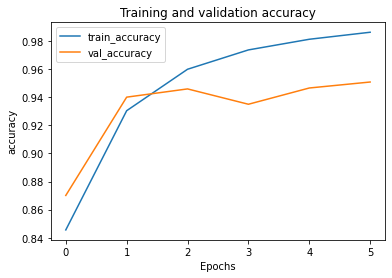

In [27]:
# Plot training and validation accuracy curves:
plot_metric(history=new_history, metric="accuracy")

In [28]:
# Run model.predict on the unseen test data:
y_pred_new = model.predict(test_generator)
y_test_new = test_generator.classes

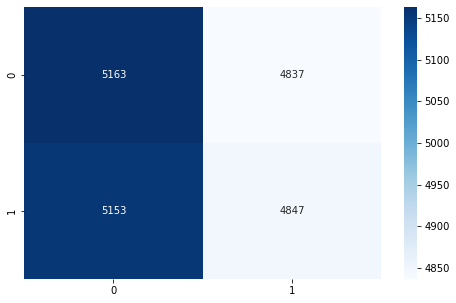

In [29]:
# Show a confusion matrix for the test predictions:
plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test_new, y_pred_new.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [30]:
# Check Area Under the Curve score:
print("ROC-AUC Score:", round(metrics.roc_auc_score(y_test_new, y_pred_new), 2))
# Check average precision score:
print("AP Score:", round(metrics.average_precision_score(y_test_new, y_pred_new), 2))

# Show classification report:
print("\n", metrics.classification_report(y_test_new, y_pred_new > 0.5))

ROC-AUC Score: 0.5
AP Score: 0.5

               precision    recall  f1-score   support

           0       0.50      0.52      0.51     10000
           1       0.50      0.48      0.49     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



It seems the model is not performing better. We would need either to let a larger part of the base model to learn (by setting more layers to `trainable=True`), or to choose a different base model.

## Conclusion

The VGG19 base model is either not suitable for an image classification transfer learning tasks, or other parameters/more learning is needed. More experiments should be performed. It it interesting to ponder the question if the dataset is not suitable for this particular network - maybe the real and fake faces are too much alike and this architecture cannot reliably distinguish between them.

## References

- [1] T. Karras, S. Laine and T. Aila, "A Style-Based Generator Architecture for Generative Adversarial Networks," 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Long Beach, CA, USA, 2019, pp. 4396-4405, doi: 10.1109/CVPR.2019.00453.
- [2] https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
- [3] Simonyan, Karen and Andrew Zisserman. “Very Deep Convolutional Networks for Large-Scale Image Recognition.” CoRR abs/1409.1556 (2014)
- [4] Kingma, Diederik P. and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” CoRR abs/1412.6980 (2014)